In [ ]:
#packages to install torch, torchvision, torchaudio, transformers, twint, emoji,tokenization

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import requests
from bs4 import BeautifulSoup
import re

In [ ]:
import twint
import nest_asyncio
nest_asyncio.apply()
import emoji
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

In [ ]:
candidate_names = ["Anne Hidalgo","Yannick Jadot", "Marine LePen","Eric Zemmour","Jean luc Melenchon", "Pecresse","Emmanuel Macron"]

In [ ]:
#web scraping tool. Avoid if using preloaded files
c = twint.Config()
for i in ["melenchon","Macron","Anne Hidalgo","Yannick Jadot","pecresse","lepen","zemmour"]:    
    c.Search = i
    c.Geo = "46.2276,2.2137,5000km"
    c.Since = "2021-07-13"  #- To use this when we update the data. 
    c.Limit = 5000
    c.Store_json = True
    c.Output = f'{i}.json'
    twint.run.Search(c)

CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 1.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 8.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 27.0 secs
CRITICAL:root:twint.run:Twint:Feed:noDataExpecting value: line 1 column 1 (char 0)
sleeping for 64.0 secs


KeyboardInterrupt: ignored

In [ ]:
dataframes = []
filenames = { # Mention 'filename': 'candidate_name'
             'macron': 'Emmanuel Macron', 
             'hidalgo': 'Anne Hidalgo', 
             'jadot': 'Yannick Jadot',
             'pecresse': 'Pecresse', 
             'lepen': 'Marine LePen',
             'zemmour': 'Eric Zemmour',
             'melenchon': 'Jean luc Melenchon'
            }

for filename in filenames.keys():
    data = pd.read_json(f'{filename}.json', lines = True)
    data['candidate'] = filenames[filename]
    dataframes.append(data)

In [ ]:
df = pd.concat(dataframes)
df.shape

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35039 entries, 0 to 5016
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   id               35039 non-null  int64         
 1   conversation_id  35039 non-null  int64         
 2   created_at       35039 non-null  datetime64[ns]
 3   date             35039 non-null  datetime64[ns]
 4   time             35039 non-null  object        
 5   timezone         35039 non-null  int64         
 6   user_id          35039 non-null  int64         
 7   username         35039 non-null  object        
 8   name             35039 non-null  object        
 9   place            35039 non-null  object        
 10  tweet            35039 non-null  object        
 11  language         35039 non-null  object        
 12  mentions         35039 non-null  object        
 13  urls             35039 non-null  object        
 14  photos           35039 non-null  object

In [ ]:
#Removing NAs from the tweet columns in the data frames
df=df[~df["tweet"].isna()]

In [ ]:
df.groupby('candidate').agg({'created_at': ['min', 'max', 'count']})

created_at                          
                                   min                 max count
candidate                                                       
Anne Hidalgo       2021-12-21 19:59:51 2021-12-26 13:44:06  5000
Emmanuel Macron    2021-12-24 18:43:35 2021-12-26 13:41:20  5002
Eric Zemmour       2021-12-24 19:17:12 2021-12-26 13:47:32  5003
Jean luc Melenchon 2021-12-21 18:02:13 2021-12-26 17:45:50  5017
Marine LePen       2021-12-17 22:08:33 2021-12-26 17:49:06  5007
Pecresse           2021-12-23 07:00:38 2021-12-26 14:00:01  5009
Yannick Jadot      2021-12-18 13:58:05 2021-12-26 13:56:08  5001

In [ ]:
# Keeping only relevant columns
keep_columns = ['candidate', 'language', 'place', 'timezone', 'tweet', 'user_id', 'created_at']
df = df[keep_columns]

# Limiting data to 5k tweets per candidate. Only latest tweets to judge the current mood of the public
df = df.sort_values(['candidate','created_at'], ascending = [True, False])
df = df.groupby('candidate').head(5000)
df.groupby('candidate').agg({'created_at': ['min', 'max', 'count']})

created_at                          
                                   min                 max count
candidate                                                       
Anne Hidalgo       2021-12-21 19:59:51 2021-12-26 13:44:06  5000
Emmanuel Macron    2021-12-24 18:43:54 2021-12-26 13:41:20  5000
Eric Zemmour       2021-12-24 19:17:36 2021-12-26 13:47:32  5000
Jean luc Melenchon 2021-12-21 18:07:05 2021-12-26 17:45:50  5000
Marine LePen       2021-12-17 22:22:25 2021-12-26 17:49:06  5000
Pecresse           2021-12-23 07:07:58 2021-12-26 14:00:01  5000
Yannick Jadot      2021-12-18 13:58:09 2021-12-26 13:56:08  5000

In [ ]:
#resetting index
df = df.reset_index()

## Cleaning Tweets

In [ ]:
punctuations = '@#!?+&*,[]-%.:/();$=><|{}^»«""'
def clean_tweets(text):
  text = text.lower()
  text = re.sub("_"," ",text)
  text = re.sub("@[A-Za-z0-9_]+","", text) #mentions
  text = re.sub("#[A-Za-z0-9_]+","", text) #hashtags
  text = re.sub(r"https?:\/\/\S+", "", text) #links
  text = re.sub(r"www.\S+", "", text) #links
  text = re.sub(r"RT[\s]+","",text) #Retweets
  text = re.sub('[()!?]', ' ', text) #punctuations
  text = re.sub('\[.*?\]',' ', text)
  text = re.sub("[0-9_]+","",text) #numbers
  text = re.sub("\n","",text) #spacing

  punctuations = '@#!?+&*,[]-%.:/();$=><|{}^»«""'
  for p in punctuations:
      text = text.replace(p, '')
  
  text = text.replace("'"," ") #apostrophe
  text = text.replace("’"," ") #apostrophe
  return text

In [ ]:
#to remove emojis
def deEmojify(text):
  '''Removes emoticons from text'''
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [ ]:
#for removing stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english') + stopwords.words('french') + stopwords.words("spanish")
additional_words = ["ça","va","le","la","lé","cette","là", "si", "déjà", "depuis" "chez", "quand","comme", "sans","donc", "très", "aussi", "faut", "faire","’"]
stop_words +=additional_words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#words to remove for each candidate
specific_words = {'Emmanuel Macron' : ['macron','emmanuel','maçron'],'Anne Hidalgo' : ['anne','hidalgo','hidalgo'],"Pecresse" :['pecresse','pécresse','valerie','valérie'],
                  'Yannick Jadot' : ['jadot','yannick','yanick'],"Eric Zemmour" : ['eric','zemmour','zemour'],"Jean luc Melenchon":['melanchon','jean','luc','jeanluc'],
                  "Marine LePen" : ['lepen','le','pen','marine','penn']}

In [ ]:
#Cleaning the tweets There are two options - remove the emojis or change the emojis to words
#df["tweet"] = df["tweet"].apply(lambda x: emoji.demojize(x, delimiters=("", ""))) #replacing emojis with words
df["tweet"] = df["tweet"].apply(lambda x: deEmojify(x)) #removing emojis
df["tweet"] = df["tweet"].apply(lambda x: clean_tweets(x.strip())) #cleaning the text
df["tweet"] = df["tweet"].apply(lambda x: ' '.join([word for word in x.lower().split() if word not in stop_words])) #removing stop words

## Tokenizing the clean tweets

In [ ]:
#tokenize text
nltk.download('punkt')
def tokenize(df):
  '''tokenizes text to get a list of words'''
  df['tokenized_text'] = [nltk.word_tokenize(x) for x in df['tweet']]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#tokenizing the tweets
tokenize(df)

In [ ]:
df["tokenized_text"][1]

['hidalgo',
 'croit',
 'malin',
 'jouant',
 'mots',
 'termes',
 'hôtel',
 'dieu',
 'plus',
 'hôpital',
 'projet',
 'aménagement',
 'envisagé',
 'novaxia',
 'clair',
 'non']

In [ ]:
#removing specific words from dataset for each candidate
grouped = df.groupby("candidate")
dataframes=[]
for i, df_iter in grouped:
  remove_words = (stop_words + list(specific_words[f'{i}']))
  df_iter['tokenized_text'] = df_iter['tokenized_text'].apply(lambda row: [word for word in row if word not in remove_words])
  dataframes.append(df_iter)
df=pd.concat(dataframes)

In [ ]:
#Changes the tokenized list to a string for Sentiment analysis
def combine(df):
  '''Combines tokenized text to a single string'''
  df['tokenized_text'] = df['tokenized_text'].apply(lambda row: " ".join(row))

In [ ]:
combine(df)

## Using Bert Model to get the sentiments - Can take in many languages

In [ ]:
#Instantiating the model
tokenizer = AutoTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

model = AutoModelForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

In [ ]:
#Function to get sentiment score
def sentiment_score(tweet):
    tokens = tokenizer.encode(tweet, return_tensors='pt')
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [ ]:
#Finding the sentiment score for each tokenized tweet
df["sentiment"] = df["tokenized_text"].apply(lambda x: sentiment_score(x[:512]))
#print(df[["candidate","tokenized_text","sentiment"]])

In [ ]:
#saving the model
df.to_csv("Dataframe.csv")

In [ ]:
def see_dist(df_1):
  '''returns the percentage distribution of sentiment in a given data frame'''
  tweets_group = df_1.groupby(['sentiment']).count()
  tweets_sum = tweets_group['user_id'].sum()
  tweets_prct=tweets_group.user_id.apply(lambda x: 100*x/tweets_sum)
  return tweets_prct

In [ ]:
#checking the distribution on the candidates
grouped = df.groupby("candidate")
j=0
for f,df_1 in grouped:
  print("\n",candidate_names[j])
  temp = see_dist(df_1)
  print(temp)
  j += 1


 Anne Hidalgo
sentiment
1    49.76
2     4.48
3    16.88
4    10.46
5    18.42
Name: user_id, dtype: float64

 Yannick Jadot
sentiment
1    50.96
2     3.92
3    14.10
4     9.28
5    21.74
Name: user_id, dtype: float64

 Marine LePen
sentiment
1    44.50
2     3.52
3    14.46
4     8.32
5    29.20
Name: user_id, dtype: float64

 Eric Zemmour
sentiment
1    50.20
2     5.14
3    18.06
4     9.96
5    16.64
Name: user_id, dtype: float64

 Jean luc Melenchon
sentiment
1    40.08
2     3.24
3    15.58
4    12.42
5    28.68
Name: user_id, dtype: float64

 Pecresse
sentiment
1    48.16
2     3.94
3    15.54
4    11.90
5    20.46
Name: user_id, dtype: float64

 Emmanuel Macron
sentiment
1    46.38
2     6.20
3    19.08
4    11.36
5    16.98
Name: user_id, dtype: float64


In [ ]:
#Distribution of the sentiments
import seaborn as sns
import matplotlib.pyplot as plt
def print_charts(i):
  fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
  plt.tight_layout()
  i.groupby('sentiment').count()['user_id'].plot(kind='pie', ax=axes[0])
  sns.countplot(x=i['sentiment'], hue=i['sentiment'], ax=axes[1])
  axes[0].set_ylabel('')
  axes[1].set_ylabel('')
  axes[1].set_xticklabels(['1', '2','3','4','5'])
  axes[0].tick_params(axis='x', labelsize=15)
  axes[0].tick_params(axis='y', labelsize=15)
  axes[1].tick_params(axis='x', labelsize=15)
  axes[1].tick_params(axis='y', labelsize=15)
  axes[1].set(ylim=(0, 5000))
  axes[1].legend()
  plt.show()



 Anne Hidalgo


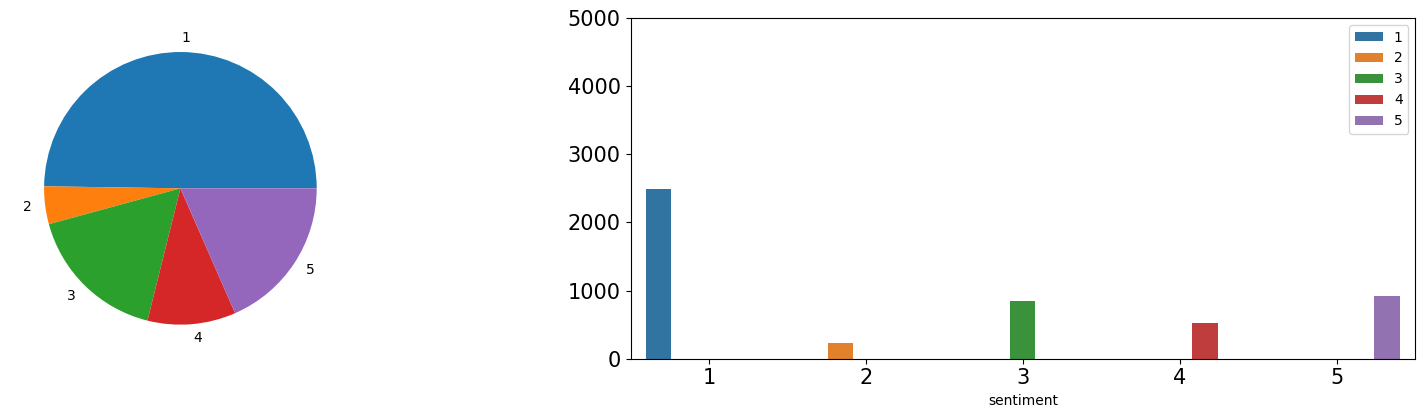


 Yannick Jadot


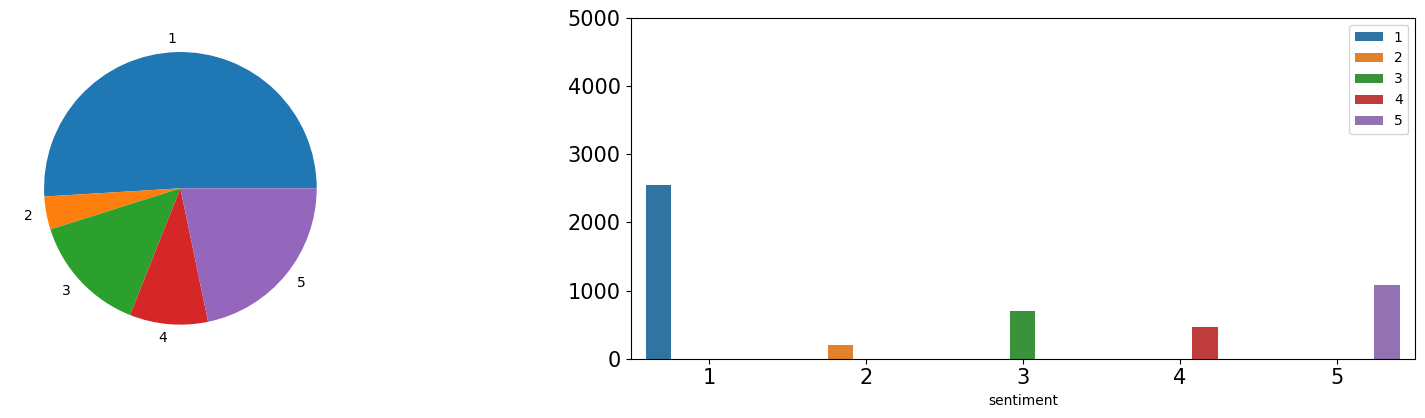


 Marine LePen


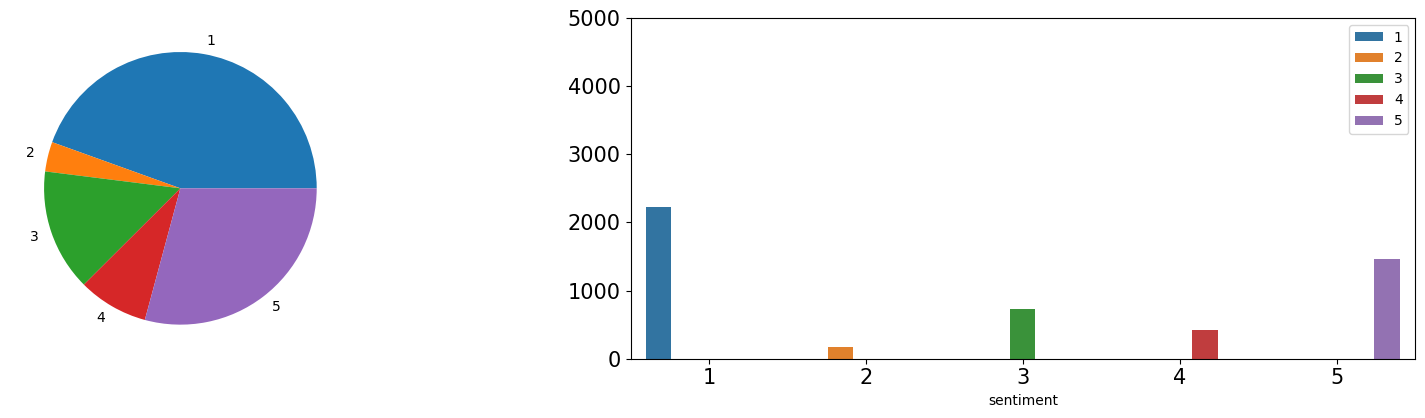


 Eric Zemmour


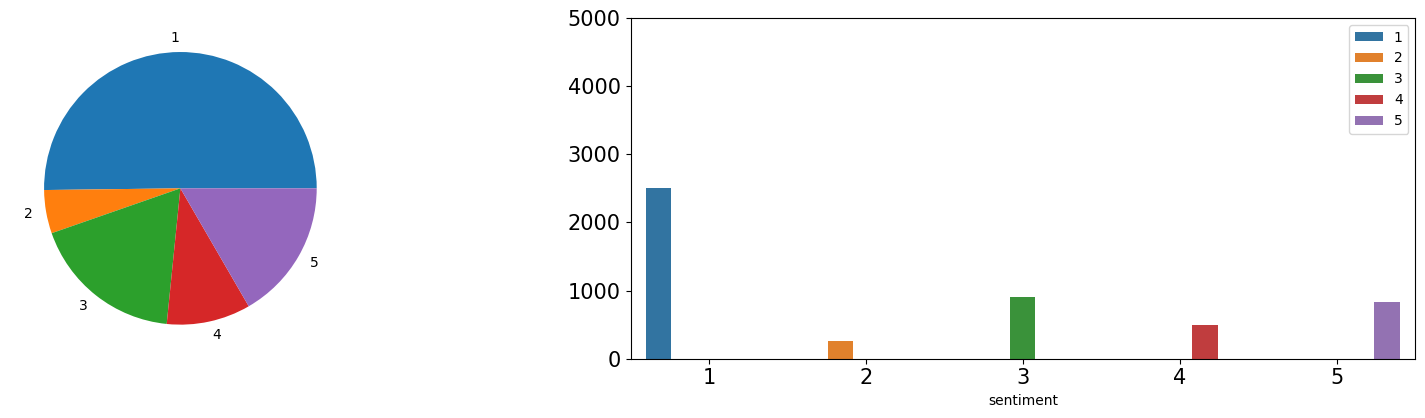


 Jean luc Melenchon


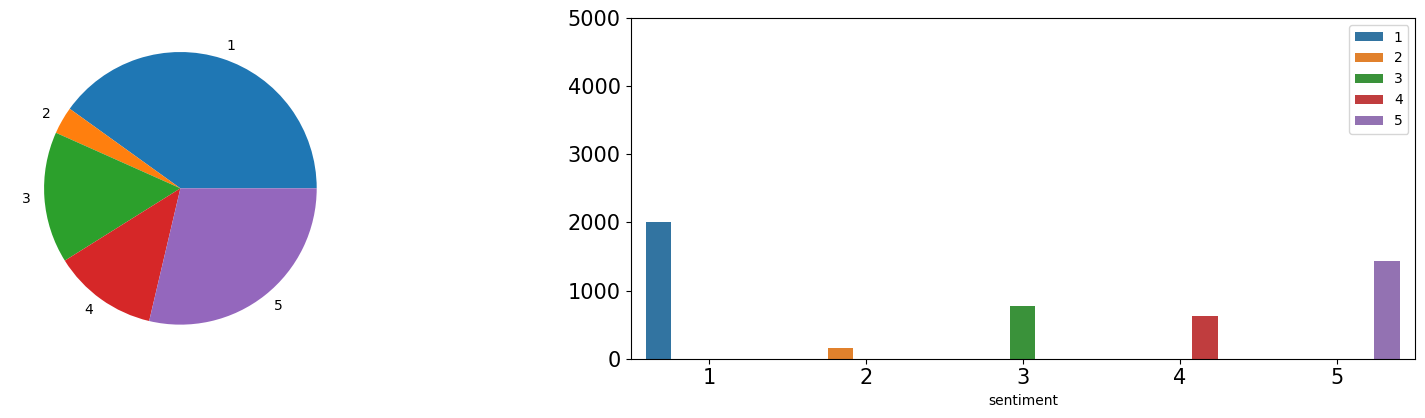


 Pecresse


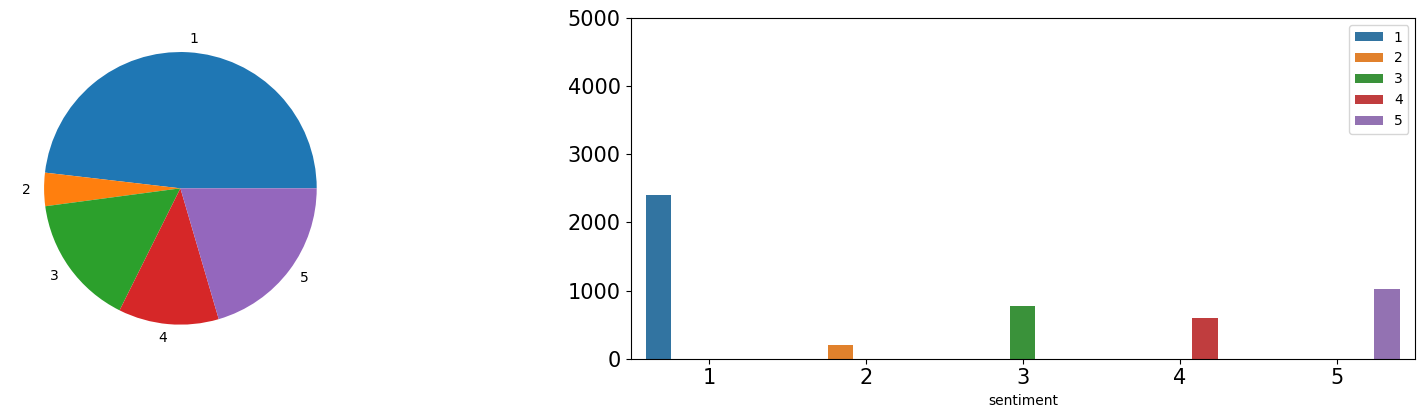


 Emmanuel Macron


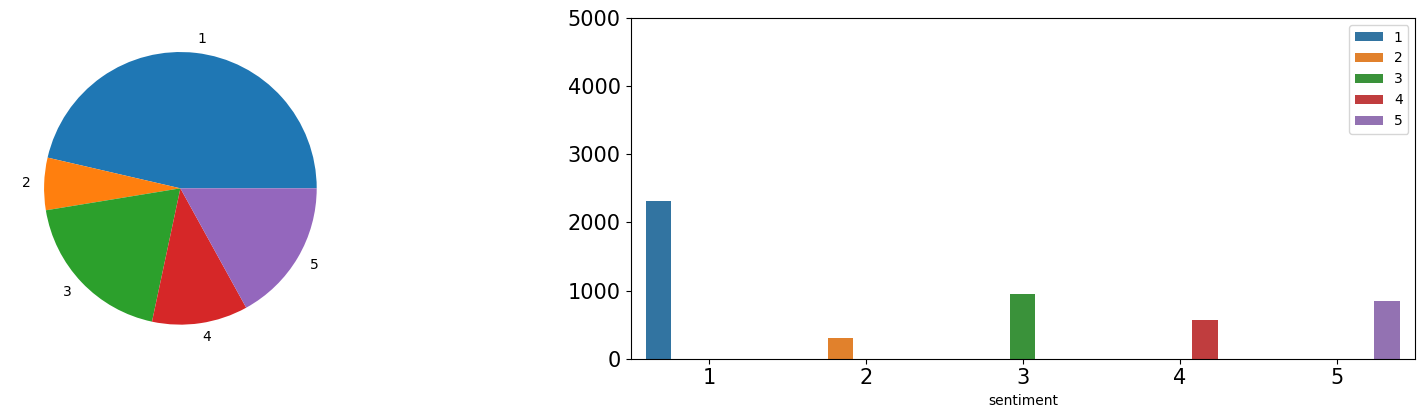

In [ ]:
#plotting the distribution for each candidate
grouped = df.groupby("candidate")
j=0
for f,df_1 in grouped:
  print("\n",candidate_names[j])
  print_charts(df_1)
  j+=1


In [ ]:
#classifying tweets with ratings 4 and 5 as Positive, 3 as Neutral, and 1 and 2 as Negative
def sentiment_over(x):
  if x>3:
    return "Positive"
  elif x<3:
    return "Negative"
  else:
    return "Neutral"

In [ ]:
df["sentiment_overall"] = df["sentiment"].apply(lambda x: sentiment_over(x))

## Word Clouds for all candidates

In [ ]:
from collections import defaultdict
from wordcloud import STOPWORDS

In [ ]:
def plotshow(word_cloud):
  '''to plot the word cloud'''
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()

In [ ]:
from wordcloud import WordCloud
def gen_word_cloud(text):
  '''calls the plotshow function to print the word cloud for each df'''
  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
  plotshow(word_cloud)


 Anne Hidalgo


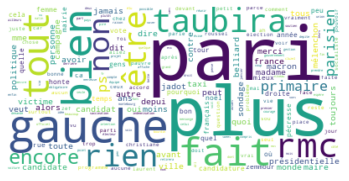


 Yannick Jadot


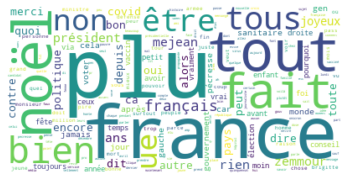


 Marine LePen


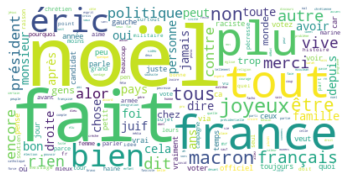


 Eric Zemmour


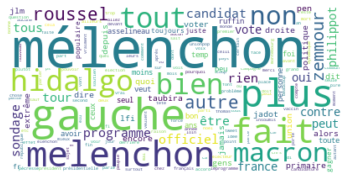


 Jean luc Melenchon


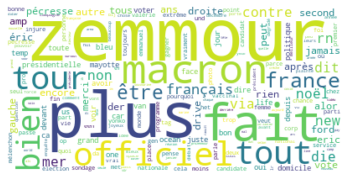


 Pecresse


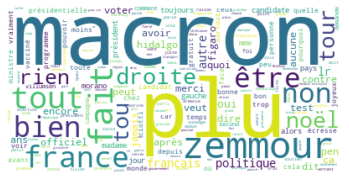


 Emmanuel Macron


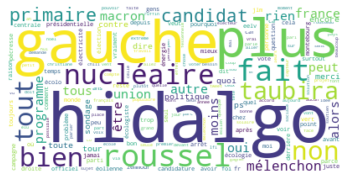

In [ ]:
#control function to print the word clouds
grouped = df.groupby("candidate")
j=0
for f,df_1 in grouped:
  print("\n",candidate_names[j])
  text = " ".join([str(text) for text in df_1['tokenized_text']])
  gen_word_cloud(str(text))
  j+=1

## N-Grams

In [ ]:
#initialization
p_unigrams,neg_unigrams,neu_unigrams,p_bigrams,neg_bigrams,neu_bigrams,p_trigrams,neg_trigrams,neu_trigrams=[],[],[],[],[],[],[],[],[]

In [ ]:
#n-grams - creating two functions, one to generate n_grams, and the second to generate n_grams for a data frame
import tokenization

def generate_ngrams(text, n_gram=1):
  '''generates n grams for some text. n_gram=1 as default'''
    text = str(text)
    token = [token for token in text.lower().split(' ') if token != '' if token not in stop_words]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]


def df_grams(df_n):
  '''Generates unigrams, bigrams and trigrams for the dataframe'''

  global p_unigrams,neg_unigrams,neu_unigrams,p_bigrams,neg_bigrams,neu_bigrams,p_trigrams,neg_trigrams,neu_trigrams

  # Unigrams
  positive_unigrams = defaultdict(int)
  negative_unigrams = defaultdict(int)
  neutral_unigrams = defaultdict(int)


  for tweet in df_n[df_n["sentiment_overall"]=="Positive"]['tokenized_text']:
      for word in generate_ngrams(tweet):
          positive_unigrams[word] += 1
          
  for tweet in df_n[df_n["sentiment_overall"]=="Negative"]['tokenized_text']:
      for word in generate_ngrams(tweet):
          negative_unigrams[word] += 1

  for tweet in df_n[df_n["sentiment_overall"]=="Neutral"]['tokenized_text']:
      for word in generate_ngrams(tweet):
          neutral_unigrams[word] += 1
          
  p_unigrams = pd.DataFrame(sorted(positive_unigrams.items(), key=lambda x: x[1])[::-1])
  neg_unigrams = pd.DataFrame(sorted(negative_unigrams.items(), key=lambda x: x[1])[::-1])
  neu_unigrams = pd.DataFrame(sorted(neutral_unigrams.items(), key=lambda x: x[1])[::-1])

  # Bigrams
  positive_bigrams = defaultdict(int)
  negative_bigrams = defaultdict(int)
  neutral_bigrams = defaultdict(int)

  for tweet in df_n[df_n["sentiment_overall"]=="Positive"]['tokenized_text']:
      for word in generate_ngrams(tweet, n_gram=2):
          positive_bigrams[word] += 1
          
  for tweet in df_n[df_n["sentiment_overall"]=="Negative"]['tokenized_text']:
      for word in generate_ngrams(tweet, n_gram=2):
          negative_bigrams[word] += 1

  for tweet in df_n[df_n["sentiment_overall"]=="Neutral"]['tokenized_text']:
      for word in generate_ngrams(tweet, n_gram=2):
          neutral_bigrams[word] += 1

  p_bigrams = pd.DataFrame(sorted(positive_bigrams.items(), key=lambda x: x[1])[::-1])
  neg_bigrams = pd.DataFrame(sorted(negative_bigrams.items(), key=lambda x: x[1])[::-1])
  neu_bigrams = pd.DataFrame(sorted(neutral_bigrams.items(), key=lambda x: x[1])[::-1])

  # Trigrams
  positive_trigrams = defaultdict(int)
  negative_trigrams = defaultdict(int)
  neutral_trigrams = defaultdict(int)

  for tweet in df_n[df_n["sentiment_overall"]=="Positive"]['tokenized_text']:
      for word in generate_ngrams(tweet, n_gram=3):
          positive_trigrams[word] += 1
          
  for tweet in df_n[df_n["sentiment_overall"]=="Negative"]['tokenized_text']:
      for word in generate_ngrams(tweet, n_gram=3):
          negative_trigrams[word] += 1

  for tweet in df_n[df_n["sentiment_overall"]=="Neutral"]['tokenized_text']:
      for word in generate_ngrams(tweet, n_gram=3):
          neutral_trigrams[word] += 1

  p_trigrams = pd.DataFrame(sorted(positive_trigrams.items(), key=lambda x: x[1])[::-1])
  neg_trigrams = pd.DataFrame(sorted(negative_trigrams.items(), key=lambda x: x[1])[::-1])
  neu_trigrams = pd.DataFrame(sorted(neutral_trigrams.items(), key=lambda x: x[1])[::-1])


In [ ]:
#unigrams
def print_unigrams(p_unigrams,neg_unigrams,neu_unigrams):
  '''print unigrams - positive, negative and neutral'''
  fig, axes = plt.subplots(ncols=3, figsize=(35, 12), dpi=100)
  plt.tight_layout()
  sns.barplot(y=p_unigrams[0].values[:N], x=p_unigrams[1].values[:N], ax=axes[0], color='green')
  sns.barplot(y=neg_unigrams[0].values[:N], x=neg_unigrams[1].values[:N], ax=axes[1], color='red')
  sns.barplot(y=neu_unigrams[0].values[:N], x=neu_unigrams[1].values[:N], ax=axes[2], color='yellow')

  for i in range(2):
      axes[i].spines['right'].set_visible(False)
      axes[i].set_xlabel('')
      axes[i].set_ylabel('')
      axes[i].tick_params(axis='x', labelsize=6)
      axes[i].tick_params(axis='y', labelsize=6)

  axes[0].set_title(f'Top {N} most common unigrams in Positive Tweets', fontsize=9)
  axes[1].set_title(f'Top {N} most common unigrams in Negative Tweets', fontsize=9)
  axes[2].set_title(f'Top {N} most common unigrams in Neutral Tweets', fontsize=9)

  plt.show()

In [ ]:
#bigrams
def print_bigrams(p_bigrams,neg_bigrams,neu_bigrams):
  '''print bigrams - positive, negative and neutral'''
  fig, axes = plt.subplots(ncols=3, figsize=(15, 8), dpi=100)
  plt.tight_layout()
  sns.barplot(y=p_bigrams[0].values[:N], x=p_bigrams[1].values[:N], ax=axes[0], color='green')
  sns.barplot(y=neg_bigrams[0].values[:N], x=neg_bigrams[1].values[:N], ax=axes[1], color='red')
  sns.barplot(y=neu_bigrams[0].values[:N], x=neu_bigrams[1].values[:N], ax=axes[2], color='yellow')

  for i in range(0):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)

  axes[0].set_title(f'Top {N} most common bigrams in Positive Tweets', fontsize=15)
  axes[1].set_title(f'Top {N} most common bigrams in Negative Tweets', fontsize=9)
  axes[2].set_title(f'Top {N} most common bigrams in Neutral Tweets', fontsize=9)

  plt.show()

In [ ]:
#trigrams
def print_trigrams(p_trigrams,neg_trigrams,neu_trigrams):
  '''print trigrams - positive, negative and neutral'''
  fig, axes = plt.subplots(ncols=3, figsize=(15, 12), dpi=100)
  plt.tight_layout()
  sns.barplot(y=p_trigrams[0].values[:N], x=p_trigrams[1].values[:N], ax=axes[0], color='green')
  sns.barplot(y=neg_trigrams[0].values[:N], x=neg_trigrams[1].values[:N], ax=axes[1], color='red')
  sns.barplot(y=neu_trigrams[0].values[:N], x=neu_trigrams[1].values[:N], ax=axes[2], color='yellow')

  for i in range(2):
      axes[i].spines['right'].set_visible(False)
      axes[i].set_xlabel('')
      axes[i].set_ylabel('')
      axes[i].tick_params(axis='x', labelsize=6)
      axes[i].tick_params(axis='y', labelsize=6)

  axes[0].set_title(f'Top {N} most common trigrams in Positive Tweets', fontsize=9)
  axes[1].set_title(f'Top {N} most common trigrams in Negative Tweets', fontsize=9)
  axes[2].set_title(f'Top {N} most common trigrams in Neutral Tweets', fontsize=9)

  plt.show()


 Anne Hidalgo


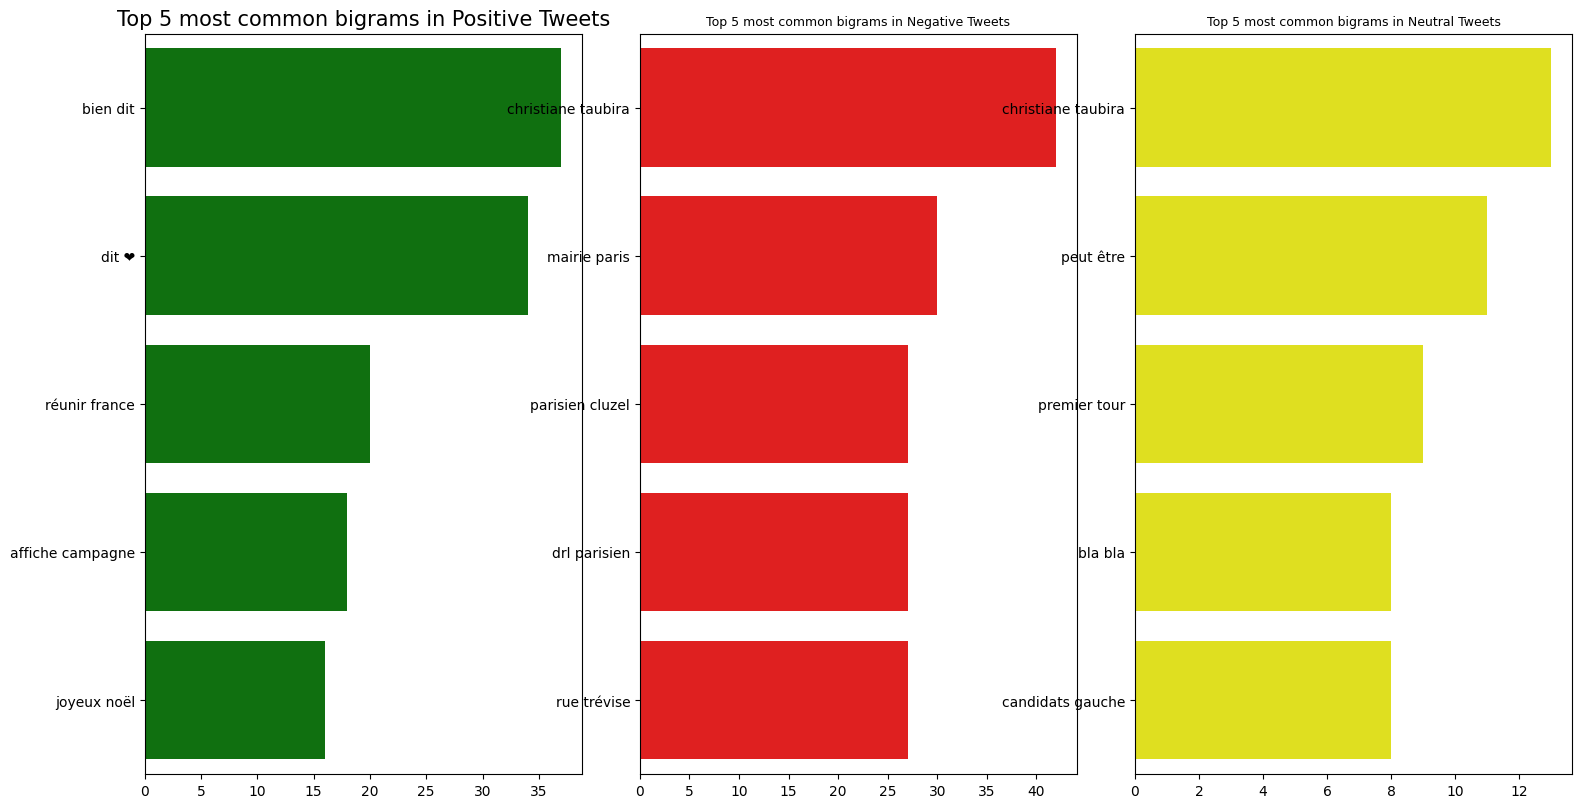


 Yannick Jadot


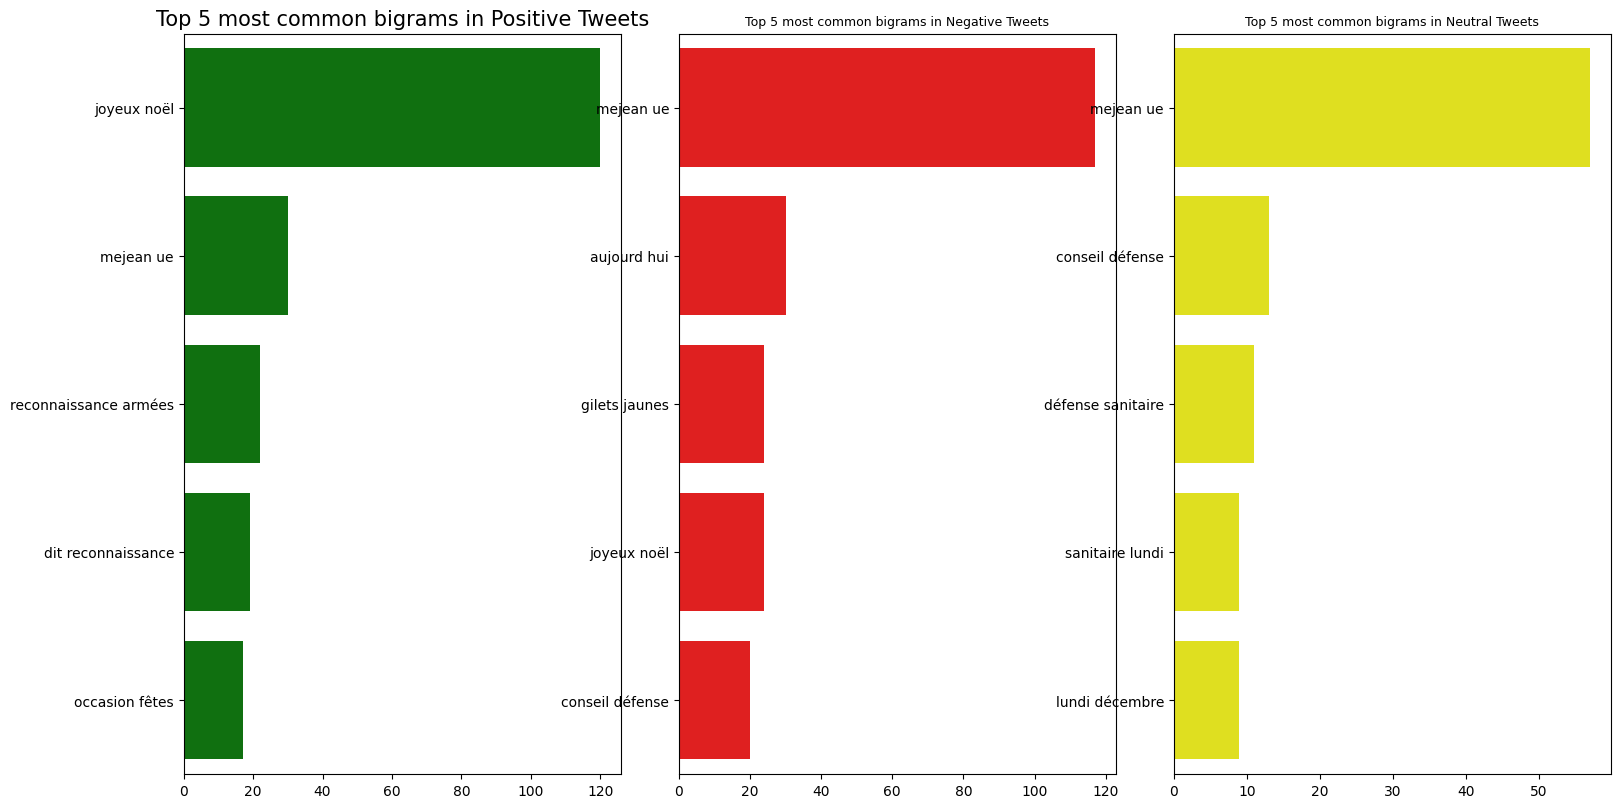


 Marine LePen


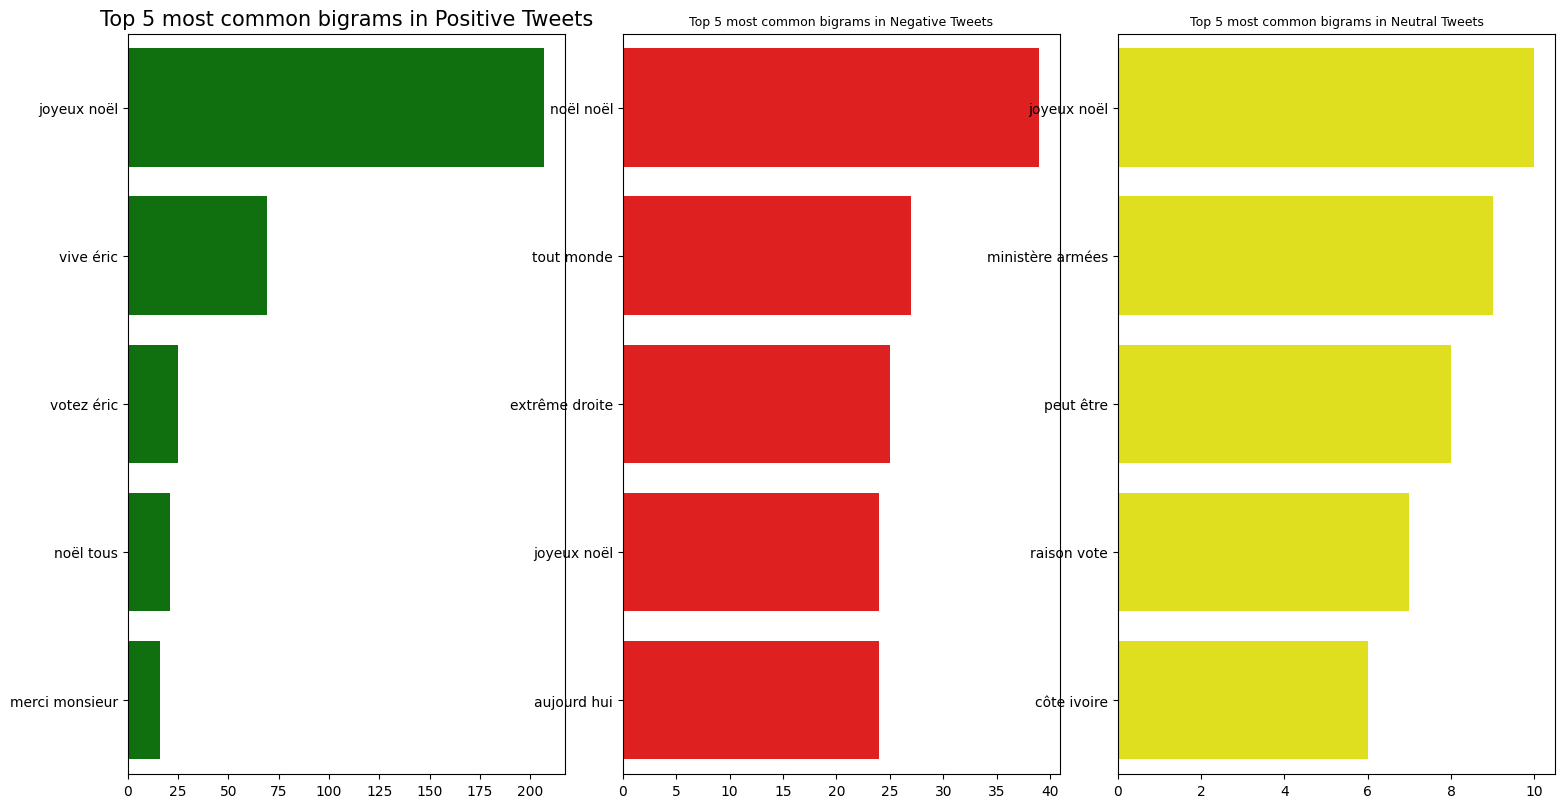


 Eric Zemmour


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9989 missing from current font.
  font.set_text(s, 0, flags=flags)


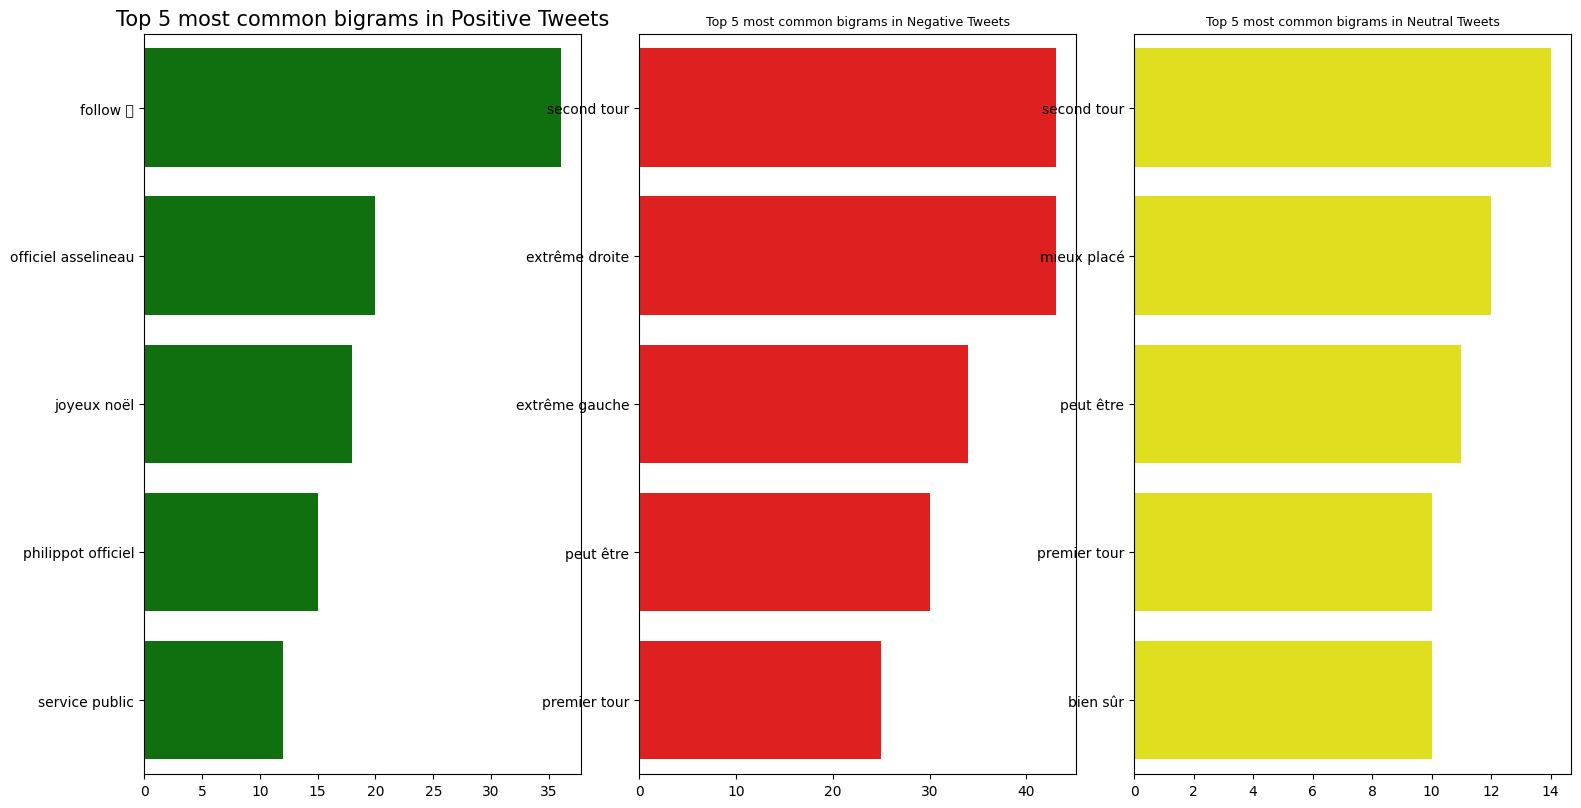


 Jean luc Melenchon


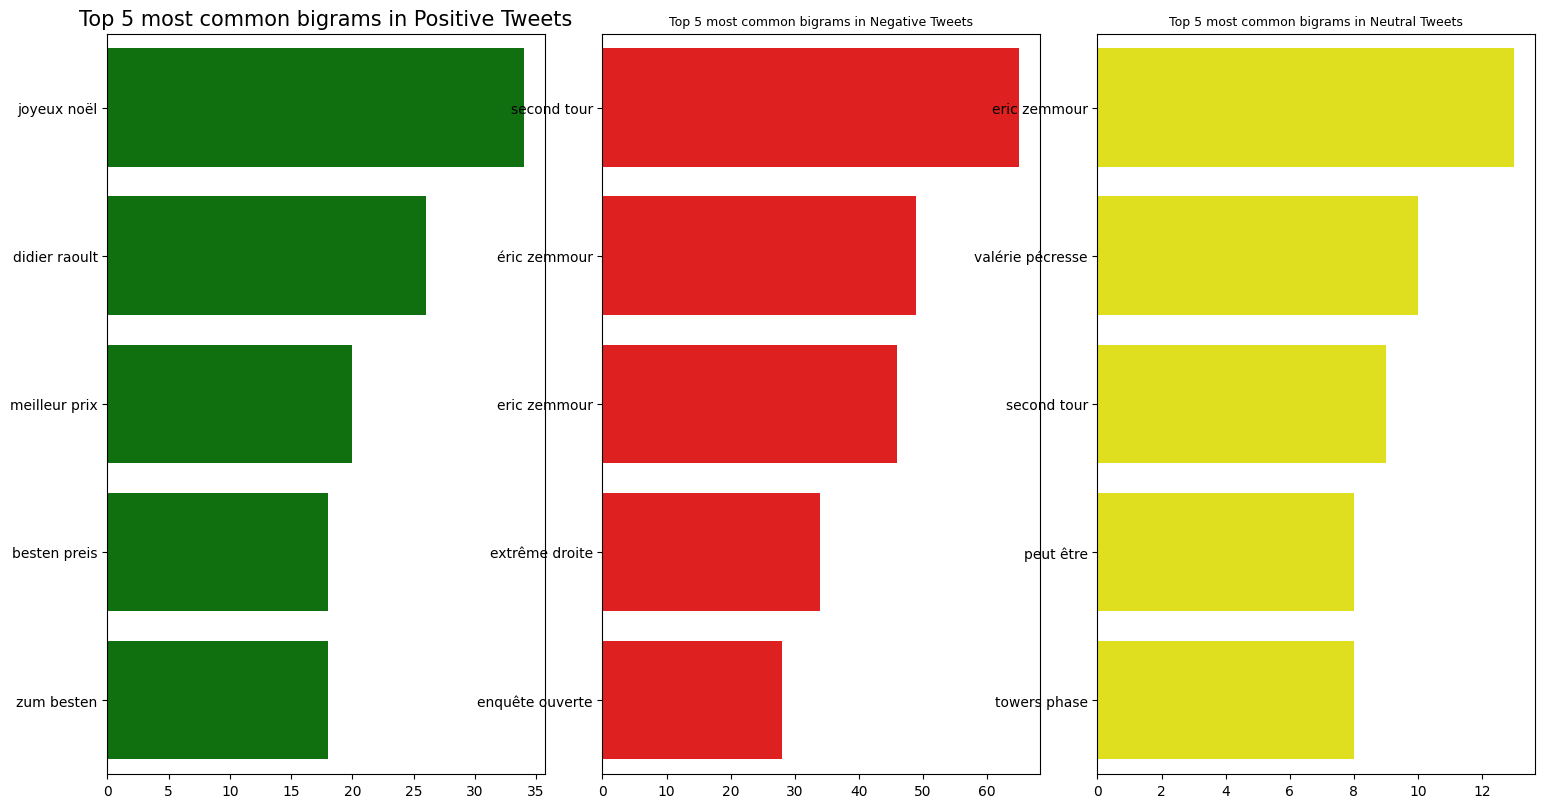


 Pecresse


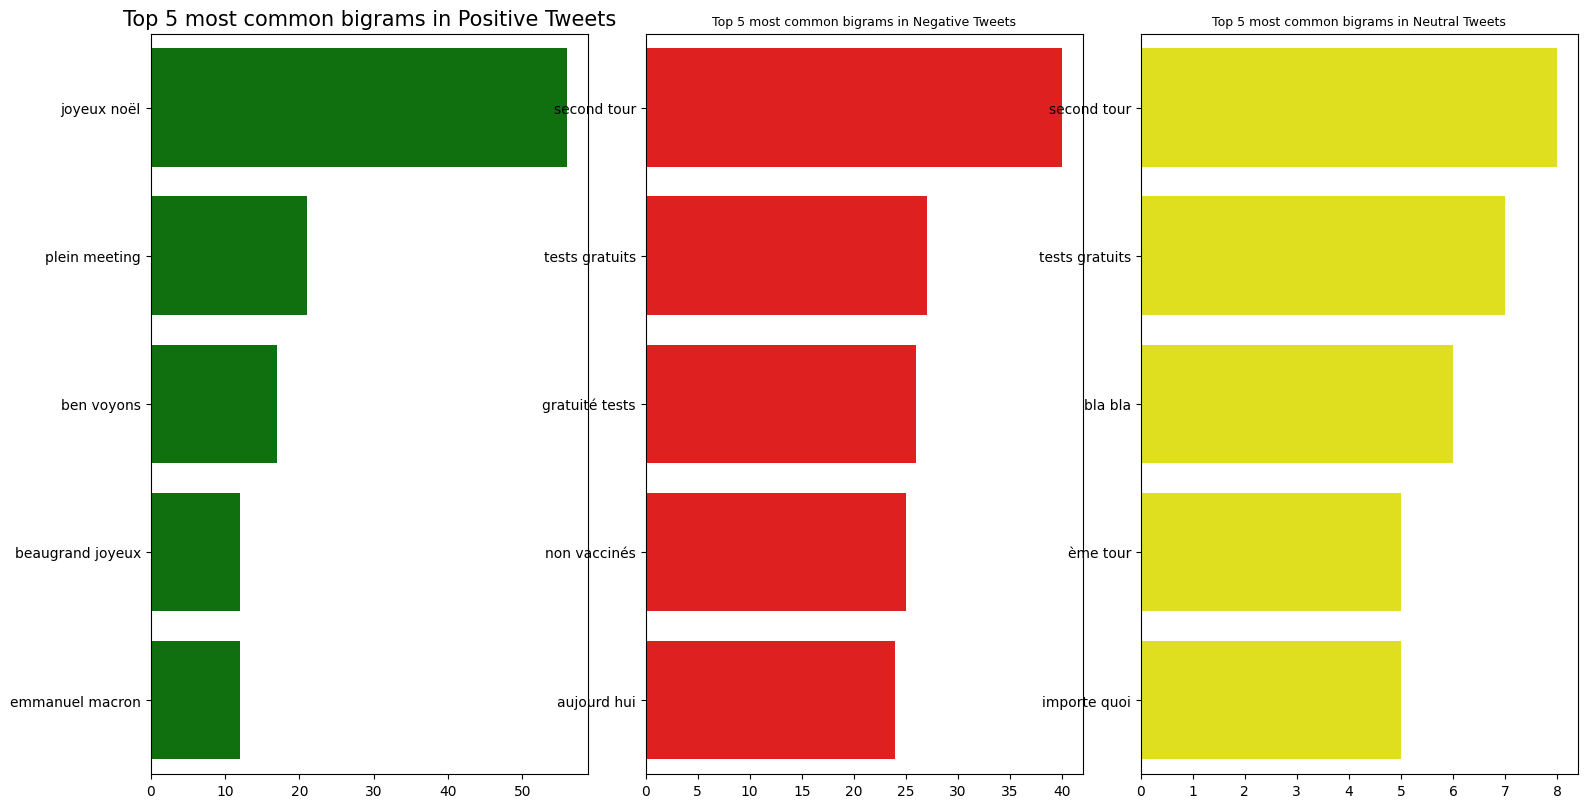


 Emmanuel Macron


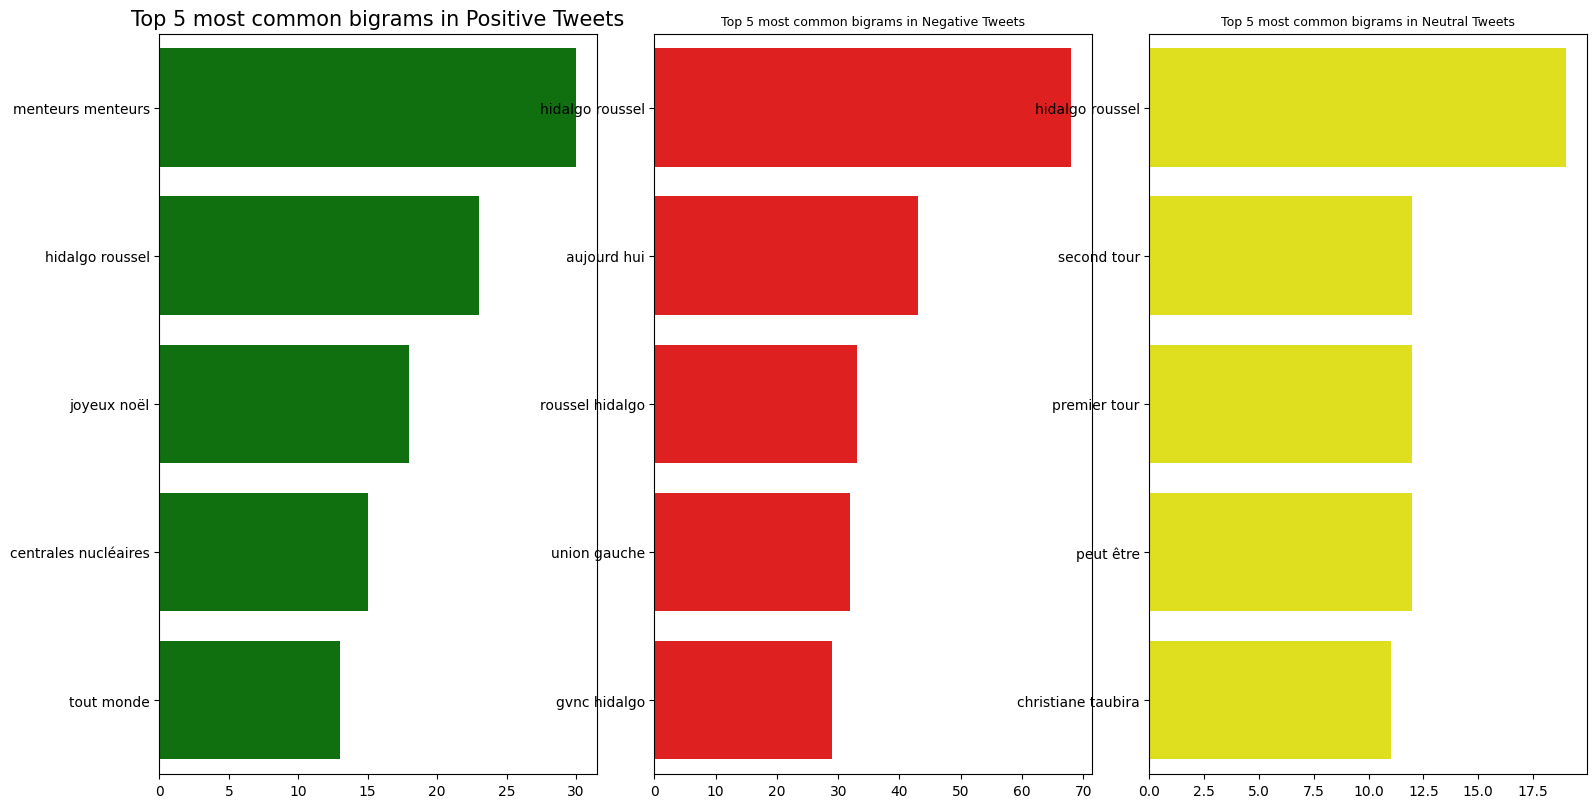

In [ ]:
grouped = df.groupby("candidate")
N=5
j=0
for f,df_1 in grouped:
  print("\n",candidate_names[j])
  temp = df_1.copy()
  df_grams(temp)
  print_unigrams(p_unigrams,neg_unigrams,neu_unigrams) #printing unigrams
  print_bigrams(p_bigrams,neg_bigrams,neu_bigrams) #printing bigrams
  print_trigrams(p_trigrams,neg_trigrams,neu_trigrams) #printing trigrams
  j+=1

## Analysing sentiment of candidates in different policy fields

In [ ]:
from collections import Counter

In [ ]:
#for analysis so as not to make changes to the original data frame
df_temp = df[["candidate","user_id","language","tweet","tokenized_text","sentiment","sentiment_overall"]]

In [ ]:
#combining all the texts to see the frequency
text = df_temp["tokenized_text"].tolist()
text=' '.join(text)

In [ ]:
#finding the frequency
Counter(text.split()).most_common()

In [ ]:
#defining keywords for each social field
covid = ["pfizer", "vaccination","moderna","hôpital","covid19","coronavirus","corona","virus", "covid","vaccin","pass","vaccinés"]
foreign_policy = ["chine","immigration","guerre","mali"]
minorities=["islam","musulmans","étranger"]
climate = ["climat","serre","émission","nucléaire","vert","ecologie"]
healthcare = ["sante","médecin","hôpital"]
others = ["violence","féministe","lgbt","femme"]

In [ ]:
for i in covid:
  df_temp["covid"] = df_temp["tokenized_text"].apply(lambda x: 1 if i in x else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in foreign_policy:
  df_temp["foreign_policy"] = df_temp["tokenized_text"].apply(lambda x: 1 if i in x else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in climate:
  df_temp["climate"] = df_temp["tokenized_text"].apply(lambda x: 1 if i in x else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
for i in minorities:
  df_temp["minorities"] = df_temp["tokenized_text"].apply(lambda x: 1 if i in x else 0)

In [ ]:
for i in healthcare:
  df_temp["healthcare"] = df_temp["tokenized_text"].apply(lambda x: 1 if i in x else 0)

In [ ]:
for i in others:
  df_temp["others"] = df_temp["tokenized_text"].apply(lambda x: 1 if i in x else 0)

In [ ]:
def print_dist(df):
  '''plots the positive sentiment for each candidate on a given field'''
  df["positive"] = df[4] + df[5]
  fig, axes = plt.subplots(ncols=1, figsize=(4, 5), dpi=100)
  plt.tight_layout()
  sns.barplot(y=df.index, x=df["positive"], order = df.sort_values("positive",ascending=False).index,ax=axes, color='green')
  axes.set_title(f'Positive sentiment of candidates', fontsize=15)
  axes.set_xlabel("Positive sentiment in %")

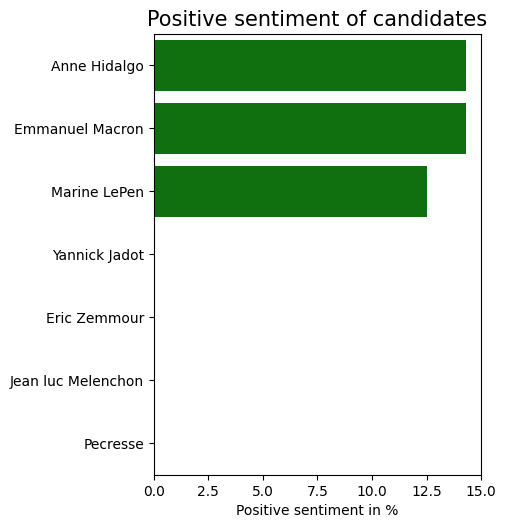

In [ ]:
#distribution of sentiment by topic

grouped = df_temp[df_temp["minorities"]==1].groupby("candidate")
j=0
minorities_dist = dict()
for f,df_1 in grouped:
  minorities_dist[f'{candidate_names[j]}'] = see_dist(df_1)
  j+=1
minorities_dist = pd.DataFrame.from_dict(minorities_dist,orient="index")
minorities_dist = minorities_dist.fillna(0)
print_dist(minorities_dist.copy())

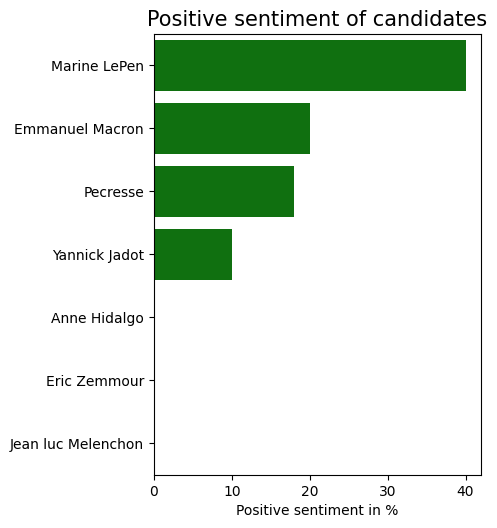

In [ ]:
#distribution of sentiment by topic
grouped = df_temp[df_temp["covid"]==1].groupby("candidate")
j=0
covid_dist = dict()
for f,df_1 in grouped:
  covid_dist[f'{candidate_names[j]}'] = see_dist(df_1)
  j+=1
covid_dist = pd.DataFrame.from_dict(covid_dist,orient="index")
covid_dist = covid_dist.fillna(0)
print_dist(covid_dist.copy())

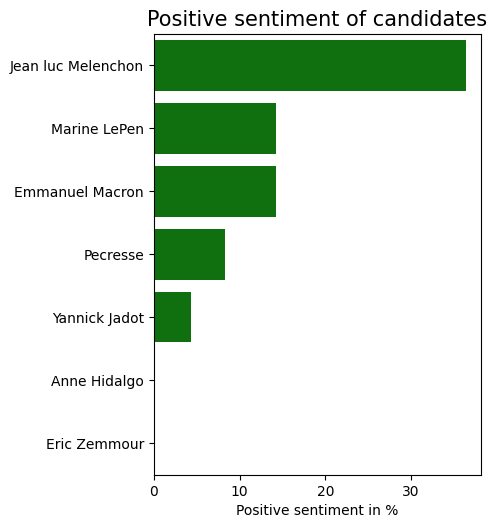

In [ ]:
grouped = df_temp[df_temp["foreign_policy"]==1].groupby("candidate")
j=0
foreign_policy_dist = dict()
for f,df_1 in grouped:
  foreign_policy_dist[f'{candidate_names[j]}'] = see_dist(df_1)
  j+=1
foreign_policy_dist = pd.DataFrame.from_dict(foreign_policy_dist, orient="index")
foreign_policy_dist = foreign_policy_dist.fillna(0)
print_dist(foreign_policy_dist.copy())

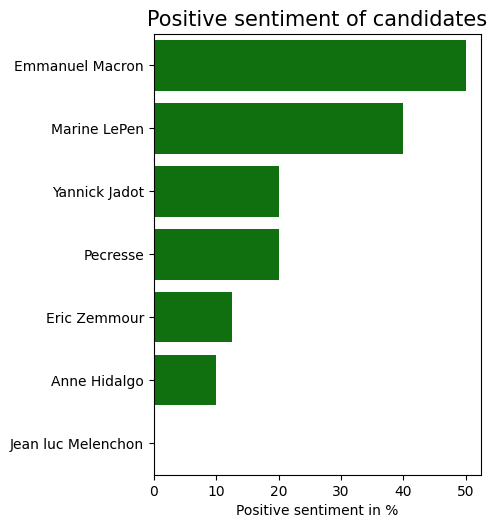

In [ ]:
grouped = df_temp[df_temp["healthcare"]==1].groupby("candidate")
j=0
healthcare_dist = dict()
for f,df_1 in grouped:
  healthcare_dist[f'{candidate_names[j]}'] = see_dist(df_1)
  j+=1
healthcare_dist = pd.DataFrame.from_dict(healthcare_dist, orient="index")
healthcare_dist = healthcare_dist.fillna(0)
print_dist(healthcare_dist.copy())

In [ ]:
grouped = df_temp[df_temp["others"]==1].groupby("candidate")
j=0
others_dist = dict()
for f,df_1 in grouped:
  others_dist[f'{candidate_names[j]}'] = see_dist(df_1)
  j+=1
others_dist = pd.DataFrame.from_dict(others_dist,orient="index")
others_dist = others_dist.fillna(0)
print_dist(others_dist.copy())

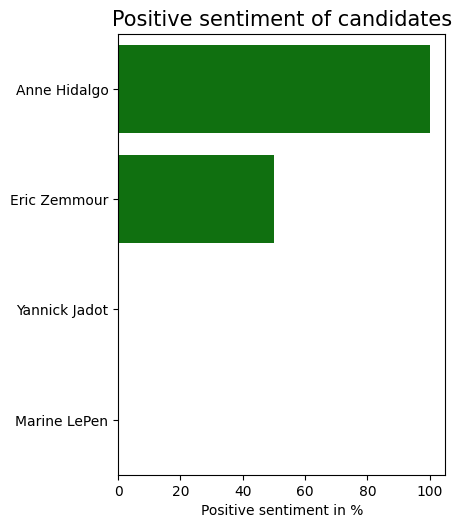

In [ ]:
grouped = df_temp[df_temp["climate"]==1].groupby("candidate")
j=0
climate_dist = dict()
for f,df_1 in grouped:
  climate_dist[f'{candidate_names[j]}'] = see_dist(df_1)
  j+=1
climate_dist = pd.DataFrame.from_dict(climate_dist,orient="index")
climate_dist = climate_dist.fillna(0)
print_dist(climate_dist.copy())